
Training with learning rate: 0.1
Epoch [1/10], Loss: 4.9120, Accuracy: 9.97%, Test Accuracy: 10.00%
Epoch [2/10], Loss: 2.3117, Accuracy: 9.97%, Test Accuracy: 10.00%
Epoch [3/10], Loss: 2.3116, Accuracy: 10.15%, Test Accuracy: 10.00%
Epoch [4/10], Loss: 2.3121, Accuracy: 9.91%, Test Accuracy: 10.00%
Epoch [5/10], Loss: 2.3105, Accuracy: 10.24%, Test Accuracy: 10.00%
Epoch [6/10], Loss: 2.3118, Accuracy: 9.98%, Test Accuracy: 10.00%
Epoch [7/10], Loss: 2.3115, Accuracy: 10.19%, Test Accuracy: 10.00%
Epoch [8/10], Loss: 2.3111, Accuracy: 10.03%, Test Accuracy: 10.00%
Epoch [9/10], Loss: 2.3119, Accuracy: 10.02%, Test Accuracy: 10.00%
Epoch [10/10], Loss: 2.3119, Accuracy: 10.00%, Test Accuracy: 10.00%

Training with learning rate: 0.01
Epoch [1/10], Loss: 2.3109, Accuracy: 9.81%, Test Accuracy: 10.00%
Epoch [2/10], Loss: 2.3037, Accuracy: 9.87%, Test Accuracy: 10.00%
Epoch [3/10], Loss: 2.3036, Accuracy: 9.92%, Test Accuracy: 10.00%
Epoch [4/10], Loss: 2.3036, Accuracy: 9.98%, Test Acc

FileNotFoundError: [Errno 2] No such file or directory: 'learning_rate_0.1.csv'

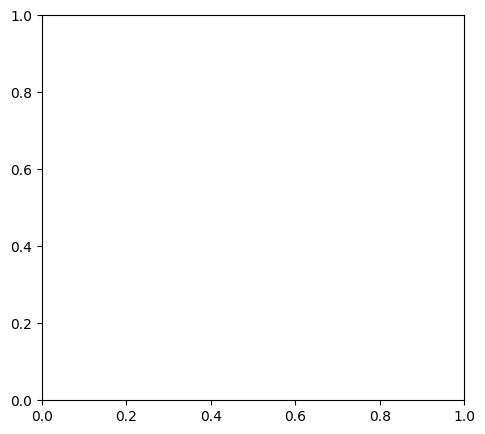

In [ ]:
# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing (normalization + data augmentation)
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Data augmentation: random rotation ±10 degrees
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load training and test datasets
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# CNN model definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function with logging to CSV
def train_model_with_logging(model, train_loader, criterion, optimizer, num_epochs, learning_rate):
    model.train()
    train_losses = []
    train_accuracies = []

    # Create logs directory (if it doesn't exist)
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/DL-小组作业", exist_ok=True)

    # Open CSV file for logging
    filename = f"/content/drive/MyDrive/Colab Notebooks/DL-小组作业/learning_rate.csv"
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_accuracy", "test_accuracy"])

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)

            # Evaluate the model on the test set
            test_loss, test_acc = test_model(model, test_loader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

            # Write to CSV
            writer.writerow([epoch+1, epoch_loss, epoch_acc, test_acc])

    return train_losses, train_accuracies

# Testing function
def test_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = 100 * correct / total
    return avg_test_loss, avg_test_acc

# Performance visualization
def plot_performance_comparison(learning_rates, num_epochs):
    plt.figure(figsize=(12, 5))

    # Plot training losses
    plt.subplot(1, 2, 1)
    for lr in learning_rates:
        filename = f"learning_rate_{lr}.csv"
        epochs, train_losses, _, _ = zip(*[map(float, row) for row in csv.reader(open(filename))][1:])
        plt.plot(epochs, train_losses, label=f"LR={lr}", marker='o')
    plt.title("Training Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot test accuracies
    plt.subplot(1, 2, 2)
    for lr in learning_rates:
        filename = f"learning_rate_{lr}.csv"
        epochs, _, _, test_accuracies = zip(*[map(float, row) for row in csv.reader(open(filename))][1:])
        plt.plot(epochs, test_accuracies, label=f"LR={lr}", marker='o')
    plt.title("Test Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

# Main loop for different learning rates
criterion = nn.CrossEntropyLoss()
learning_rates = [0.1, 0.01, 0.001, 0.0001]
num_epochs = 10

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train and log results
    train_model_with_logging(model, train_loader, criterion, optimizer, num_epochs, lr)

# Visualize performance comparison
plot_performance_comparison(learning_rates, num_epochs)